# Table of contents

1. [Training and test](#training)    
    1. [ROC](#roc)    
2. [Validation](#validation)    
    1. [Confusion matrices](#confusion)    
    2. [ROC](#roc_val)    
    3. [Error metrics](#error)    
    4. [Spearman correlation](#spearman)    
    5. [Distribution of the data](#distribution)      

<a id='training'></a>
# Training and test

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('features.lst', 'r') as file:
    features = file.read().splitlines()

In [3]:
# Read the data
training = pd.read_csv('training_set.csv.gz', compression='gzip')
training[['CID','activity'] + features].head()

,CID,activity,GATS3m,GATS1m,AATS4i,GATS1pe,GATS4m,GATS3se,ATSC2m
0,JAG-UCB-4709a583-1,0,0.970061,0.537791,163.606396,0.665118,0.953853,0.957548,-7.853283
1,LON-WEI-b8d98729-9,0,0.962716,0.501345,156.473669,0.640952,0.764865,1.127119,-88.020465
2,MAT-POS-916a2c5a-2,1,0.930692,0.736034,156.298629,0.733243,1.085959,1.053636,-26.534927
3,ERI-BAS-37e2bb46-1,0,0.981993,0.723451,164.587065,0.742251,1.259074,0.993863,6.320989
4,LON-WEI-adc59df6-1,0,1.051077,0.833837,161.930498,0.668320,0.956446,0.942484,396.856136


In [4]:
# Set output precision to 2 decimal places
pd.set_option('precision', 2)

In [5]:
def get_model_by_name(model_name):
    if model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=500, max_depth=6, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=13)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='binary:logistic', n_estimators=200, 
            max_depth=5, eta=0.01, random_state=13)
    elif model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV applies probability transformation 
        # on top of the SVC outputs, so we can plot its ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))
    
    
def train_test_scores(X_train, X_test, y_train, y_test, pipe):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from imblearn.metrics import geometric_mean_score
    
    scores = []
    
    y_pred = pipe.predict(X_test)
    scores.append(f1_score(y_test, y_pred))              # test_f1
    scores.append(geometric_mean_score(y_test, y_pred))  # test_geometric_mean
    
    y_proba = pipe.predict_proba(X_test)[:,1]
    scores.append(roc_auc_score(y_test, y_proba))        # test_roc_auc
    
    y_pred = pipe.predict(X_train)
    scores.append(f1_score(y_train, y_pred))             # train_f1
    scores.append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
    
    y_proba = pipe.predict_proba(X_train)[:,1]
    scores.append(roc_auc_score(y_train, y_proba))       # train_roc_auc
    
    return scores


def feature_transformer(X):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import OneHotEncoder

    return ColumnTransformer(transformers=[
        ('continuous', StandardScaler(), X.select_dtypes(include=float).columns.tolist()), 
        ('discrete', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=int).columns.tolist())
    ])

In [6]:
def get_tpr_KFold(X, y, pipe, base_fpr):
    from sklearn.metrics import roc_curve
    
    y_proba = pipe.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1])
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    return tpr

def plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name):
    # Test mean ROC
    tpr_test = np.mean(tpr_test_list, axis=0)
    tpr_test[-1] = 1.0
    axis[0].plot(base_fpr, tpr_test, label=model_name)

    # Training mean ROC
    tpr_train = np.mean(tpr_train_list, axis=0)
    tpr_train[-1] = 1.0
    axis[1].plot(base_fpr, tpr_train, label=model_name)

def get_scores_KFold(X, y, pipe, base_fpr):
    from sklearn.model_selection import RepeatedStratifiedKFold
    
    scores_KFold = []
    tpr_train_list = []
    tpr_test_list = []
    
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=5)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        
        # Fit Pipeline
        pipe.fit(X_train, y_train)

        # Test and training scores
        scores_KFold.append(train_test_scores(X_train, X_test, y_train, y_test, pipe))
        
        # Test TPR (True Positive Rate)
        tpr_test_list.append(get_tpr_KFold(X_test, y_test, pipe, base_fpr))
        # Training TPR
        tpr_train_list.append(get_tpr_KFold(X_train, y_train, pipe, base_fpr))
    
    return scores_KFold, tpr_train_list, tpr_test_list

def kFold_pipeline(X, y, clf, transformer, axis):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    from sklearn.model_selection import RepeatedStratifiedKFold

    base_fpr = np.linspace(0, 1, 101)
    pipe = make_pipeline(SMOTE(random_state=42), transformer, clf)
        
    scores_KFold, tpr_train_list, tpr_test_list = get_scores_KFold(X, y, pipe, base_fpr)
    
    # Plot mean ROC curve
    plot_train_test_roc(axis, tpr_test_list, tpr_train_list, base_fpr, model_name)
    
    scores = pd.DataFrame(scores_KFold)
    mean_scores = scores.mean().tolist()
    return mean_scores

In [7]:
# ML classfifiers
classifiers = ['LogisticRegression','RandomForestClassifier','KNeighborsClassifier','LinearSVC','XGBClassifier']

y = training['activity']
X = training[features]

transformer = feature_transformer(X)

<a id='roc'></a>
## ROC

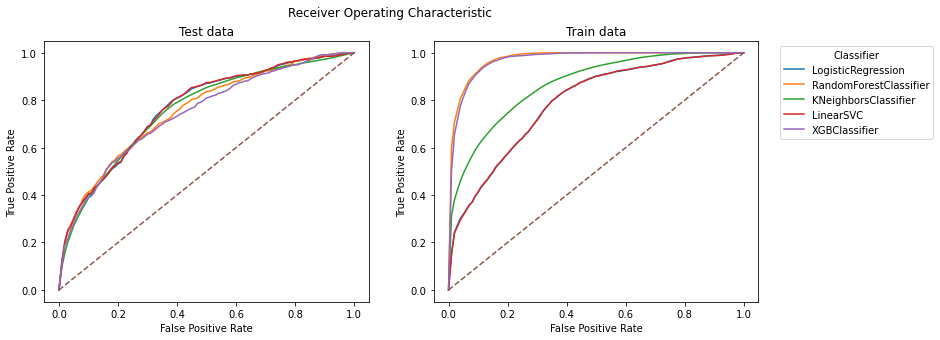

,test_f1,test_geometric_mean,test_roc_auc,train_f1,train_geometric_mean,train_roc_auc,clf,test_mean,train_mean
0,0.46,0.68,0.77,0.48,0.70,0.79,LogisticRegression,0.63,0.66
1,0.47,0.67,0.76,0.78,0.91,0.97,RandomForestClassifier,0.63,0.89
2,0.47,0.70,0.76,0.54,0.76,0.87,KNeighborsClassifier,0.64,0.73
3,0.46,0.68,0.77,0.48,0.70,0.79,LinearSVC,0.63,0.66
4,0.46,0.67,0.74,0.78,0.91,0.97,XGBClassifier,0.63,0.89


In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))

scores = []
for model_name in classifiers:
    clf = get_model_by_name(model_name)
    model_scores = kFold_pipeline(X, y, clf, transformer, axis=ax)
    model_scores.append(model_name)
    scores.append(model_scores)

test_metrics = ['test_f1', 'test_geometric_mean', 'test_roc_auc']
train_metrics = ['train_f1', 'train_geometric_mean', 'train_roc_auc']
columns = test_metrics + train_metrics + ['clf']

scores = pd.DataFrame(scores, columns=columns)
scores['test_mean'] = scores[test_metrics].mean(axis=1)
scores['train_mean'] = scores[train_metrics].mean(axis=1)

# Labels and legend
ax[0].set(title='Test data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[0].plot([0,1], [0,1], linestyle='--')
ax[1].set(title='Train data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[1].plot([0,1], [0,1], linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Classifier', bbox_to_anchor=(1.05, 1))
plt.suptitle('Receiver Operating Characteristic')
plt.savefig('figures/roc_curve.png', bbox_inches='tight', dpi=250)
plt.show()

scores

In [9]:
print(scores[['clf','test_f1','test_geometric_mean','test_roc_auc','test_mean']].to_latex(index=False, float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
                    clf &  test\_f1 &  test\_geometric\_mean &  test\_roc\_auc &  test\_mean \\
\midrule
     LogisticRegression &     0.46 &                 0.68 &          0.77 &       0.63 \\
 RandomForestClassifier &     0.47 &                 0.67 &          0.76 &       0.63 \\
   KNeighborsClassifier &     0.47 &                 0.70 &          0.76 &       0.64 \\
              LinearSVC &     0.46 &                 0.68 &          0.77 &       0.63 \\
          XGBClassifier &     0.46 &                 0.67 &          0.74 &       0.63 \\
\bottomrule
\end{tabular}



In [10]:
print(scores[['clf','train_f1','train_geometric_mean','train_roc_auc','train_mean']].to_latex(index=False, float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
                    clf &  train\_f1 &  train\_geometric\_mean &  train\_roc\_auc &  train\_mean \\
\midrule
     LogisticRegression &      0.48 &                  0.70 &           0.79 &        0.66 \\
 RandomForestClassifier &      0.78 &                  0.91 &           0.97 &        0.89 \\
   KNeighborsClassifier &      0.54 &                  0.76 &           0.87 &        0.73 \\
              LinearSVC &      0.48 &                  0.70 &           0.79 &        0.66 \\
          XGBClassifier &      0.78 &                  0.91 &           0.97 &        0.89 \\
\bottomrule
\end{tabular}



<a id='validation'></a>
# Validation

In [8]:
validation = pd.read_csv('validation_set.csv.gz', compression='gzip')
y_val = validation['activity']
X_val = validation[features]

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

Y = pd.DataFrame(validation['CID'])
probas = pd.DataFrame(validation['CID'])

for model_name in classifiers:
    clf = get_model_by_name(model_name)
    pipe = make_pipeline(SMOTE(random_state=42), transformer, clf)
    pipe.fit(X, y)
    
    y_pred = pipe.predict(X_val)
    Y[model_name] = y_pred
    
    y_proba = pipe.predict_proba(X_val)
    probas[model_name] = y_proba[:,1]

<a id='confusion'></a>
## Confusion matrices

In [13]:
def print_confusion_matrix(y_true, y_pred):
    from sklearn.metrics import confusion_matrix  
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    matrix = pd.DataFrame(conf_matrix)
    print(matrix.round(2))

In [14]:
for model_name in classifiers:
    print('\n', model_name)
    print_confusion_matrix(y_val, Y[model_name])
    
# TN FN
# FP TP


 LogisticRegression
      0     1
0  0.68  0.32
1  0.31  0.69

 RandomForestClassifier
      0     1
0  0.79  0.21
1  0.42  0.58

 KNeighborsClassifier
      0     1
0  0.64  0.36
1  0.22  0.78

 LinearSVC
      0     1
0  0.67  0.33
1  0.31  0.69

 XGBClassifier
      0     1
0  0.75  0.25
1  0.28  0.72


<a id='roc_val'></a>
## ROC

Classifier          	AUC	F1 	G-Mean
LogisticRegression  	0.72	0.53	0.69
RandomForestClassifier	0.78	0.53	0.68
KNeighborsClassifier	0.76	0.55	0.71
LinearSVC           	0.72	0.53	0.68
XGBClassifier       	0.78	0.59	0.73


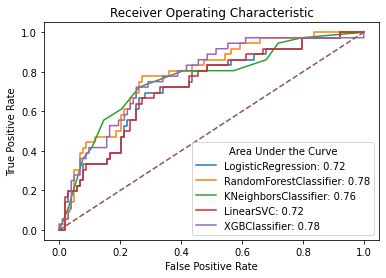

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from imblearn.metrics import geometric_mean_score

print('{:20s}\t{:3s}\t{:3s}\t{:3s}'.format('Classifier', 'AUC', 'F1', 'G-Mean'))

for model_name in classifiers:
    y_proba = probas[model_name]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name}: {auc_score:>.2f}')
    
    f1 = f1_score(y_val, Y[model_name])
    geometric_mean = geometric_mean_score(y_val, Y[model_name])
    print(f'{model_name:20s}\t{auc_score:.2f}\t{f1:.2f}\t{geometric_mean:.2f}')

plt.plot([0,1], [0,1], linestyle='--')
plt.legend(title='Area Under the Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.savefig('figures/roc_curve_validation.png', dpi=200)
plt.show()

<a id='error'></a>
## Error metrics

In [16]:
def error_metrics(y_true, y_proba):
    import numpy as np
    from sklearn.metrics import log_loss
    
    rmse = np.linalg.norm(y_proba - y_true) / np.sqrt(len(y_true))
    logl = log_loss(y_true, y_proba)
    return rmse, logl

In [17]:
error = []
for model_name in classifiers:
    rmse, logl = error_metrics(y_val, probas[model_name])
    error.append([model_name, rmse, logl])

error = pd.DataFrame(error, columns=['clf', 'rmse', 'log_loss'])
error

,clf,rmse,log_loss
0,LogisticRegression,0.46,0.63
1,RandomForestClassifier,0.42,0.54
2,KNeighborsClassifier,0.47,1.55
3,LinearSVC,0.46,0.62
4,XGBClassifier,0.43,0.54


In [18]:
print(error.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                    clf &  rmse &  log\_loss \\
\midrule
     LogisticRegression &  0.46 &      0.63 \\
 RandomForestClassifier &  0.42 &      0.54 \\
   KNeighborsClassifier &  0.47 &      1.55 \\
              LinearSVC &  0.46 &      0.62 \\
          XGBClassifier &  0.43 &      0.54 \\
\bottomrule
\end{tabular}



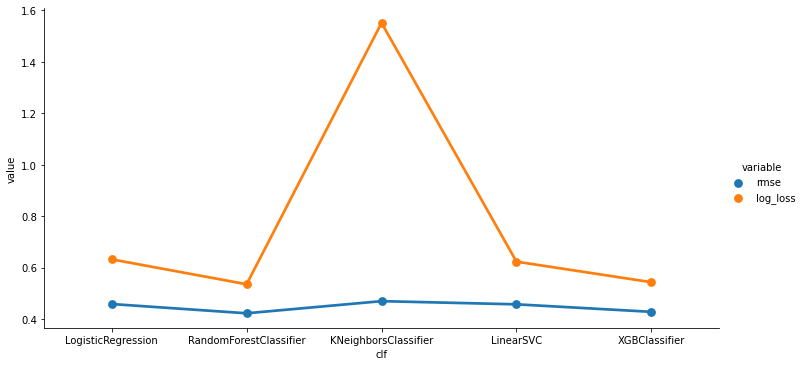

In [19]:
melt = pd.melt(error, id_vars='clf', value_vars=['rmse', 'log_loss'])
sns.catplot(kind='point', data=melt, x='clf', y='value', hue='variable', aspect=2)
plt.savefig('figures/error-metrics.png', dpi=128)

<a id='spearman'></a>
## Spearman correlation

In [10]:
from scipy.stats import spearmanr

activity = pd.read_csv('activity_data.csv')
docking = pd.read_csv('docking.csv')
docking_list = docking.columns.tolist()[1:]

df = pd.merge(activity[['CID', 'f_inhibition_at_50_uM']], docking, on=['CID'])
df = pd.merge(df, probas, on=['CID'])

In [14]:
melt = pd.melt(df, id_vars=['CID','f_inhibition_at_50_uM'], value_vars=docking_list+classifiers)

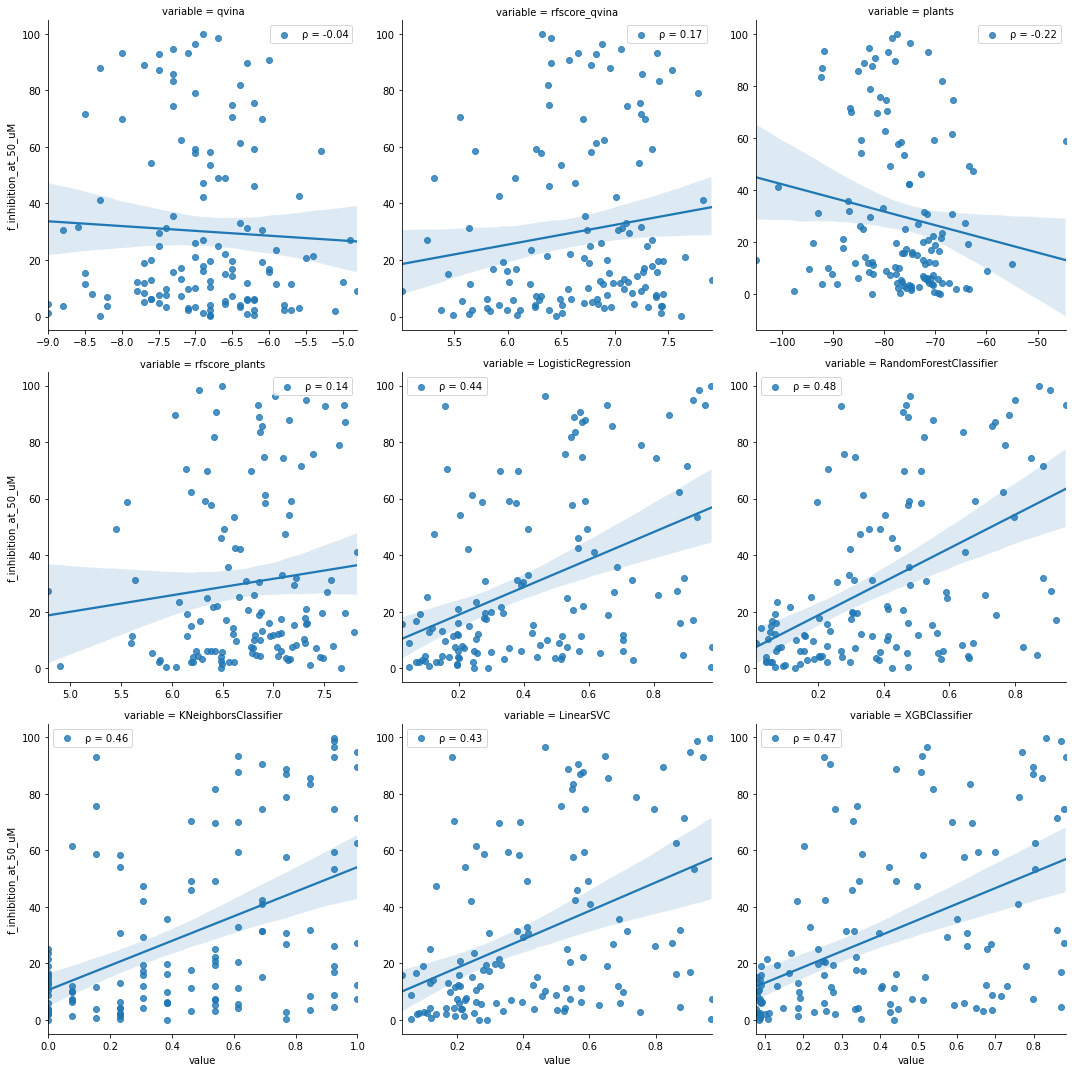

In [15]:
spearman = []

g = sns.lmplot(data=melt, x='value', y='f_inhibition_at_50_uM', col='variable', sharey=False, sharex=False, col_wrap=3)
for ax, col in zip(g.axes.flatten(), g.col_names):
    r, pvalue = spearmanr(df['f_inhibition_at_50_uM'], df[col])
    spearman.append([col, r, pvalue])
    ax.collections[0].set_label(f'ρ = {r:.2f}')
    ax.legend()

plt.tight_layout()
plt.savefig('figures/regression.png', dpi=200)
plt.show()

In [23]:
spearman = pd.DataFrame(spearman, columns=['SF', 'spearman_r', 'p_value'])
spearman

,SF,spearman_r,p_value
0,qvina,-0.04,6.30e-01
1,rfscore_qvina,0.17,5.30e-02
2,plants,-0.22,1.06e-02
3,rfscore_plants,0.14,1.06e-01
4,LogisticRegression,0.44,2.16e-07
5,RandomForestClassifier,0.48,6.70e-09
6,KNeighborsClassifier,0.46,3.37e-08
7,LinearSVC,0.43,2.62e-07
8,XGBClassifier,0.47,1.34e-08


<a id='distribution'></a>
## Distribution of the data

In [24]:
def percentage_dist(values):
    values = pd.Series(values, name='values')
    distribution = values.value_counts(
        normalize=True).mul(100).reset_index().rename({'values':'Percentage','index':'Class'}, axis=1)
    return distribution

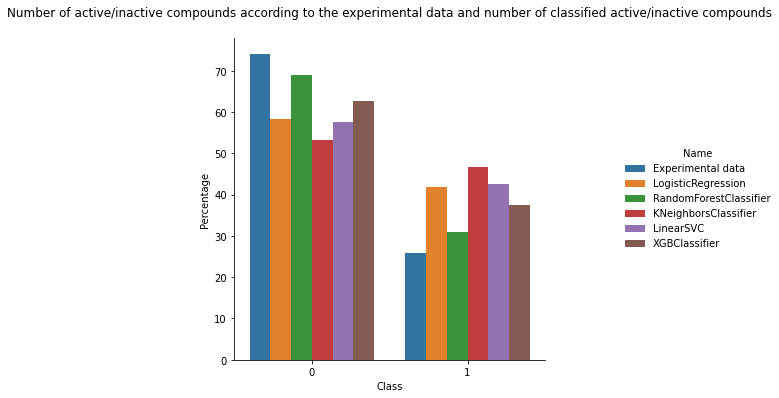

In [25]:
perc = percentage_dist(y_val)
perc['Name'] = 'Experimental data'

for model_name in classifiers:
    y_pred = Y[model_name]
    dist = percentage_dist(y_pred)
    dist['Name'] = model_name
    perc = perc.append(dist)

sns.catplot(kind='bar', data=perc, x='Class', y='Percentage', hue='Name')
plt.title('Number of active/inactive compounds according to the experimental data and number of classified active/inactive compounds', y=1.05)
plt.show()

Text(0.5, 1.0, 'Number of missed actives')

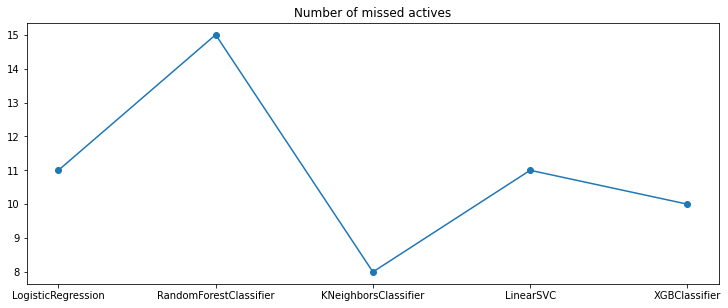

In [26]:
Y['experimental'] = y_val
count = [Y.query(f'{model_name} == 0 and experimental == 1').count().values[0] for model_name in classifiers]
plt.figure(figsize=(12.4, 4.8))
plt.plot(classifiers, count, marker='o')
plt.title('Number of missed actives')